In [1]:
# Étape 1 : Chargement et aperçu du texte
with open("wolof.txt", "r", encoding="utf-8") as f:
    wolof_text = f.read()

# Afficher les 500 premiers caractères
print(" First 500 Characters:\n")
print(wolof_text[:500])
# 
print("Last 500 characters:\n")
print(wolof_text[-500:])

 First 500 Characters:

Ndawu réew boobu di Gaal de defa mel ni deñoo naxarlu ‘niróó ak ay walakaana’
Njakkare amna si yenn Ndaw ci lu ñeel soppi seen tur boobu di MWPs ( Ndawu pencum réeww boobu di Gaal ).
Li jogloo jooju mbir bokk na ci pexe ngir soppi tuuru pencum ndawu réew mi defaat ko Peccum réew bu Gaal.
Ci seen mbootaayu politik, ndawu réew boobu jakknanu ci ni mbir. mi mune dem ba soof
Kenn ci ndawu parti boobu tuddu Ligeey neena ay ñooñam jakk nañu lool ndax mbir yi ‘ndof ak ay dof day lay niru.’
Ngir tarikat
Last 500 characters:

celot et un Chat sauvage. 
Gar yi 
Gnathostomata Super-classe Tetrapoda Classe Mammalia Sous-classe Theria Infra-classe Eutheria Ordre Carnivora Sous-ordre Caniformia Famille Canidae Genre Canis Espèce Canis lupus Linnaeus, 1758 Répartition géographique Aire de répartition des sous-espèces sauvages non férales. Boy gi 
Fransois Hollande [1955] (ci Faraañse mooy François Hollande) Nekkoon na nitu guur gu Fraas, moo sos juróomeelu gaw bu Fraas 1958, j

### 🔹 Étape 2 : Entraîner un tokenizer adapté au wolof (avec SentencePiece)

In [2]:
import sentencepiece as spm

# Nom du modèle SentencePiece à créer
tokenizer_model_prefix = "wolof_tokenizer"

# Entraîner le tokenizer sur ton fichier `wolof.txt`
spm.SentencePieceTrainer.train(
    input='wolof.txt',
    model_prefix=tokenizer_model_prefix,
    vocab_size=8000,  # Tu peux ajuster ça selon la taille de ton corpus
    model_type='bpe',  # Peut aussi être 'unigram'
    character_coverage=1.0,  # Pour conserver tous les caractères (utile pour wolof)
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: wolof.txt
  input_format: 
  model_prefix: wolof_tokenizer
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differentia

### 🔹 Étape 3 : Tokeniser tout le texte wolof et créer les datasets train / validation

In [3]:
import sentencepiece as spm

# Charger le tokenizer entraîné
sp = spm.SentencePieceProcessor()
sp.load("wolof_tokenizer.model")

# Charger le texte brut
with open("wolof.txt", "r", encoding="utf-8") as f:
    wolof_text = f.read()

# Encoder tout le texte en ID de tokens
token_ids = sp.encode(wolof_text, out_type=int)

# # Vérifier la taille
# print(f"Nombre total de tokens : {len(token_ids)}")

# Fractionner en 90% train, 10% validation
train_ratio = 0.9
split_index = int(len(token_ids) * train_ratio)

train_ids = token_ids[:split_index]
val_ids = token_ids[split_index:]

# Sauvegarder les jeux de données encodés
import pickle

with open("train_tokens.pkl", "wb") as f:
    pickle.dump(train_ids, f)

with open("val_tokens.pkl", "wb") as f:
    pickle.dump(val_ids, f)

print("✅ Jeux de données encodés sauvegardés.")

# Nombre de caractères
total_chars = len(wolof_text)

# Nombre de tokens
total_tokens = len(token_ids)

print(f"Nombre total de caractères : {total_chars}")
print(f"Nombre total de tokens     : {total_tokens}")

✅ Jeux de données encodés sauvegardés.
Nombre total de caractères : 965763
Nombre total de tokens     : 236093


### 🔹 Étape 4 : Créer les DataLoaders pour l’entraînement et la validation

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Charger les tokens encodés
import pickle

with open("train_tokens.pkl", "rb") as f:
    train_ids = pickle.load(f)

with open("val_tokens.pkl", "rb") as f:
    val_ids = pickle.load(f)

# Configuration
context_length = 256  # séquence de 256 tokens
batch_size = 64        # Augmente la taille du batch pour accélérer l'entraînement (

# Réduction du dataset pour test rapide (prendre seulement 10 000 tokens pour train, 1 000 pour val)
train_ids = train_ids[:10000]  # Limite le nombre de tokens pour l'entraînement
val_ids = val_ids[:1000]       # Limite le nombre de tokens pour la validation

# Dataset personnalisé
class TokenDataset(Dataset):
    def __init__(self, tokens, context_length):
        self.tokens = tokens
        self.context_length = context_length

    def __len__(self):
        return len(self.tokens) - self.context_length

    def __getitem__(self, idx):
        chunk = self.tokens[idx:idx + self.context_length + 1]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y

# Création des DataLoaders
train_dataset = TokenDataset(train_ids, context_length)
val_dataset = TokenDataset(val_ids, context_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("✅ DataLoaders créés avec succès.")


✅ DataLoaders créés avec succès.


In [5]:
num_train_batches = len(train_loader)
num_val_batches = len(val_loader)

print(f"Nombre de batchs d'entraînement : {num_train_batches}")
print(f"Nombre de batchs de validation  : {num_val_batches}")

Nombre de batchs d'entraînement : 153
Nombre de batchs de validation  : 12


In [6]:
# ...après la création des DataLoaders...

# --- Sanity check pour la taille des datasets ---
if len(train_ids) < context_length:
    print("⚠️ Pas assez de tokens pour le train loader. "
          "Diminue 'context_length' ou augmente 'train_ratio'.")

if len(val_ids) < context_length:
    print("⚠️ Pas assez de tokens pour le validation loader. "
          "Diminue 'context_length' ou diminue 'train_ratio'.")

# --- Comptage des tokens utilisés par les DataLoaders ---
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print(f"Training tokens: {train_tokens}")
print(f"Validation tokens: {val_tokens}")
print(f"All tokens: {train_tokens + val_tokens}")

Training tokens: 2494464
Validation tokens: 190464
All tokens: 2684928


###  Étape 5 : Initialiser le modèle GPT

#### Étape 5.1 – Configuration du modèle

In [15]:
GPT_CONFIG = {
    "vocab_size": 8000,       # Doit correspondre à ton tokenizer SentencePiece
    "context_length": 256,    # Même que dans le DataLoader
    "emb_dim": 512,           # Taille de l'embedding
    "n_heads": 8,             # Nombre de têtes d'attention
    "n_layers": 6,            # Nombre de couches transformer
    "drop_rate": 0.1,
    "qkv_bias": True
}


#### Étape 5.2 – Initialiser le modèle

In [8]:
import torch
from training_library import GPTModel

model = GPTModel(GPT_CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✅ Modèle initialisé sur {device}")


✅ Modèle initialisé sur cpu


###  🔹 Étape 6 : Boucle d’entraînement du modèle

### Étape 6.1 – Préparation de l’entraînement

In [16]:
import torch
import torch.nn.functional as F
from training_library import GPTModel
import time

# Recharger config et modèle
model = GPTModel(GPT_CONFIG).to(device)

# Optimiseur
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Nombre d'époques
num_epochs = 5  # 1 seule époque pour vérifier le fonctionnement


NameError: name 'device' is not defined

####  Étape 6.2 – Boucle d'entraînement complète


🚀 Époque 1/5
  [Batch 100] Tokens vus : 1638400 | Loss : 4.5393
  [Batch 153] Tokens vus : 2494464 | Loss : 2.3406

✅ Fin de l’époque 1 - Train Loss : 5.3346 | Val Loss : 9.2679 | Temps : 3180s

🚀 Époque 2/5
  [Batch 100] Tokens vus : 4132864 | Loss : 0.5885
  [Batch 153] Tokens vus : 4988928 | Loss : 0.1958

✅ Fin de l’époque 2 - Train Loss : 0.9694 | Val Loss : 8.1145 | Temps : 3153s

🚀 Époque 3/5
  [Batch 100] Tokens vus : 6627328 | Loss : 0.0545
  [Batch 153] Tokens vus : 7483392 | Loss : 0.0353

✅ Fin de l’époque 3 - Train Loss : 0.0843 | Val Loss : 7.2100 | Temps : 3227s

🚀 Époque 4/5
  [Batch 100] Tokens vus : 9121792 | Loss : 0.0241
  [Batch 153] Tokens vus : 9977856 | Loss : 0.0197

✅ Fin de l’époque 4 - Train Loss : 0.0261 | Val Loss : 6.9834 | Temps : 5062s

🚀 Époque 5/5
  [Batch 100] Tokens vus : 11616256 | Loss : 0.0144
  [Batch 153] Tokens vus : 12472320 | Loss : 0.0161

✅ Fin de l’époque 5 - Train Loss : 0.0165 | Val Loss : 6.7715 | Temps : 3172s


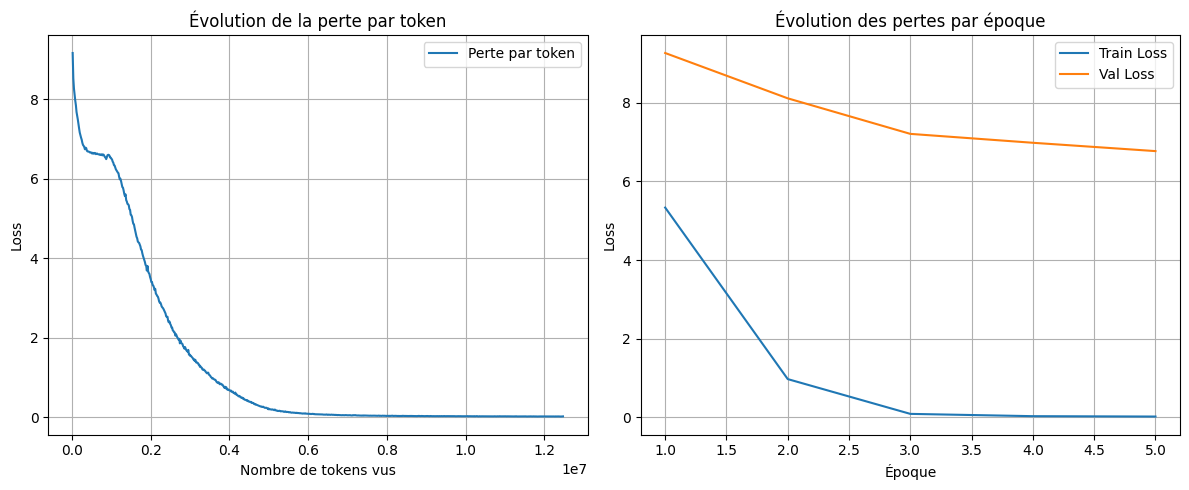

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

# Suivi des pertes
losses_per_token = []
tokens_seen = []
losses_per_epoch = []
val_losses_per_epoch = []

total_tokens_seen = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start_time = time.time()

    print(f"\n🚀 Époque {epoch+1}/{num_epochs}")

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Prédiction et calcul de la perte
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Suivi de la perte
        total_loss += loss.item()
        current_tokens = x.numel()
        total_tokens_seen += current_tokens
        losses_per_token.append(loss.item())
        tokens_seen.append(total_tokens_seen)

        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            print(f"  [Batch {i+1}] Tokens vus : {total_tokens_seen} | Loss : {loss.item():.4f}")

    # Moyenne de perte pour l'époque
    avg_train_loss = total_loss / len(train_loader)
    losses_per_epoch.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses_per_epoch.append(avg_val_loss)

    print(f"\n✅ Fin de l’époque {epoch+1} - Train Loss : {avg_train_loss:.4f} | Val Loss : {avg_val_loss:.4f} | Temps : {int(time.time() - start_time)}s")

# 📈 Affichage des courbes de perte
plt.figure(figsize=(12, 5))

# 1. Perte batch par batch (par token)
plt.subplot(1, 2, 1)
plt.plot(tokens_seen, losses_per_token, label="Perte par token")
plt.xlabel("Nombre de tokens vus")
plt.ylabel("Loss")
plt.title("Évolution de la perte par token")
plt.grid(True)
plt.legend()

# 2. Perte moyenne par époque
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), losses_per_epoch, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses_per_epoch, label="Val Loss")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Évolution des pertes par époque")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
torch.save(model.state_dict(), "gpt_wolof.pt")
print("✅ Modèle GPT sauvegardé dans 'gpt_wolof.pt'")


✅ Modèle GPT sauvegardé dans 'gpt_wolof.pt'


### 🔹 Étape 7 : Générer du texte en wolof avec ton modèle entraîné


In [9]:
import sentencepiece as spm

# Charger le tokenizer
sp = spm.SentencePieceProcessor()
sp.load("wolof_tokenizer.model")


True

In [10]:
# Si tu as redémarré l’environnement, recharge le modèle :
model = GPTModel(GPT_CONFIG).to(device)
model.load_state_dict(torch.load("gpt_wolof.pt", map_location=device))
model.eval()


NameError: name 'GPTModel' is not defined

In [6]:
def generate_text(model, prompt_text, tokenizer, max_new_tokens=50):
    model.eval()
    device = next(model.parameters()).device

    # Encoder le prompt
    input_ids = tokenizer.encode(prompt_text, out_type=int)
    input_ids = input_ids[:GPT_CONFIG["context_length"]]
    input_tensor = torch.tensor([input_ids], dtype=torch.long, device=device)

    for _ in range(max_new_tokens):
        input_cond = input_tensor[:, -GPT_CONFIG["context_length"]:]
        with torch.no_grad():
            logits = model(input_cond)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        input_tensor = torch.cat((input_tensor, next_token), dim=1)

    # Décoder les tokens en texte
    generated_ids = input_tensor[0].tolist()
    return tokenizer.decode(generated_ids)


In [7]:
# Exemples de prompt en wolof :
prompt = "no góor gi,"

generated = generate_text(model, prompt, sp, max_new_tokens=20)
print("📜 Texte généré :\n")
print(generated)


NameError: name 'model' is not defined